# **Assignment 3 - RRN - Weather Time Series Forcasting**

# **Name: Nisha Chaurasia**

# **Date: 11-04-2023**

**A temperature-forecasting example- Data Upload from mazon Web Services (AWS) /keras**

In [ ]:
!pip install tensorflow==2.12

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-05 00:11:18--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.46.222, 52.217.137.168, 16.182.33.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.46.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  40.6MB/s    in 0.3s    

2023-11-05 00:11:19 (40.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

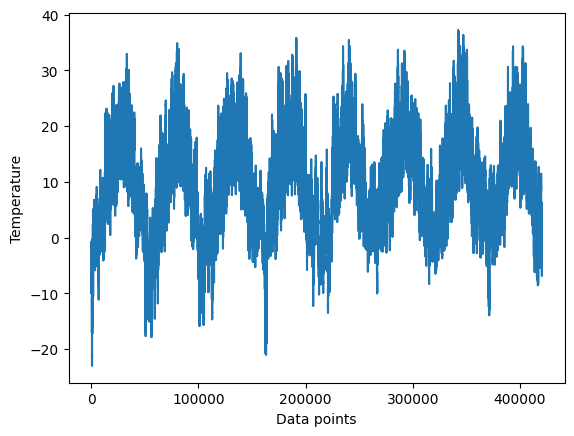

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points**

Text(0, 0.5, 'Temperature')

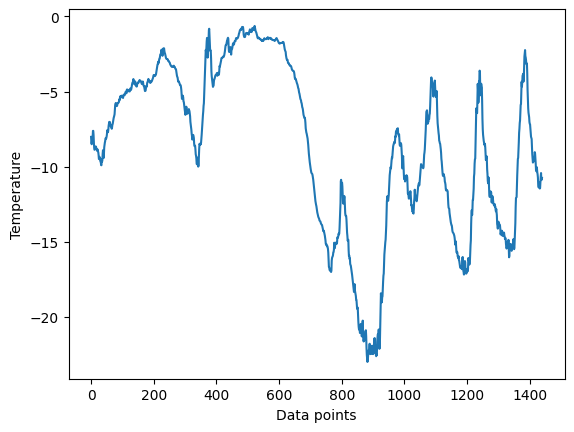

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **A common-sense, non-machine-learning baseline**

**Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Common-sense baseline approach is to predict that the temperature 24 hours ahead will be identical to the current temperature. By using this straightforward baseline, the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

### **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 9s 10ms/step - loss: 12.9873 - mae: 2.7883 - val_loss: 10.7692 - val_mae: 2.5914
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 9.0569 - mae: 2.3686 - val_loss: 10.6384 - val_mae: 2.5702
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 8.2545 - mae: 2.2618 - val_loss: 11.7405 - val_mae: 2.7027
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 7.8007 - mae: 2.1995 - val_loss: 11.1802 - val_mae: 2.6378
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.5021 - mae: 2.1559 - val_loss: 11.6182 - val_mae: 2.7016
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 7.2406 - mae: 2.1207 - val_loss: 11.4659 - val_mae: 2.6858
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 7.0471 - mae: 2.0903 - val_loss: 11.0757 - val_mae: 2.6420
Epoch 8/10
819/819 [==============================] - 8s 10ms

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 7ms/step - loss: 11.4950 - mae: 2.6675
Test MAE: 2.67


**Plotting results**

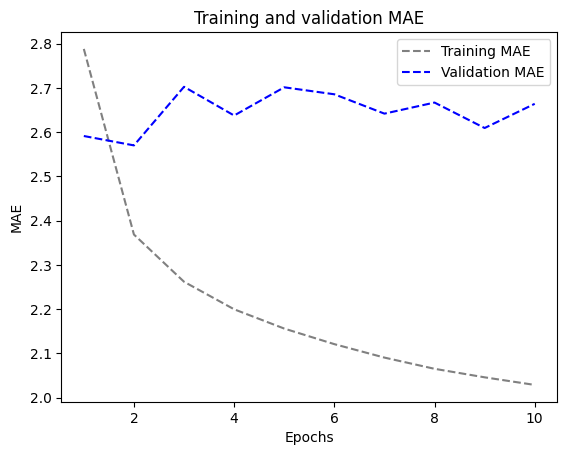

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Let's try a 1D convolutional model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 15ms/step - loss: 22.4288 - mae: 3.7253 - val_loss: 17.9793 - val_mae: 3.2744
Epoch 2/10
819/819 [==============================] - 12s 14ms/step - loss: 15.9791 - mae: 3.1849 - val_loss: 14.5266 - val_mae: 3.0300
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 14.7830 - mae: 3.0575 - val_loss: 15.6301 - val_mae: 3.0963
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 13.9303 - mae: 2.9650 - val_loss: 14.8295 - val_mae: 3.0523
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 13.2338 - mae: 2.8889 - val_loss: 15.5705 - val_mae: 3.0993
Epoch 6/10
819/819 [==============================] - 12s 14ms/step - loss: 12.6517 - mae: 2.8177 - val_loss: 15.6440 - val_mae: 3.1147
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 12.1284 - mae: 2.7597 - val_loss: 18.0461 - val_mae: 3.3647
Epoch 8/10
819/819 [============================

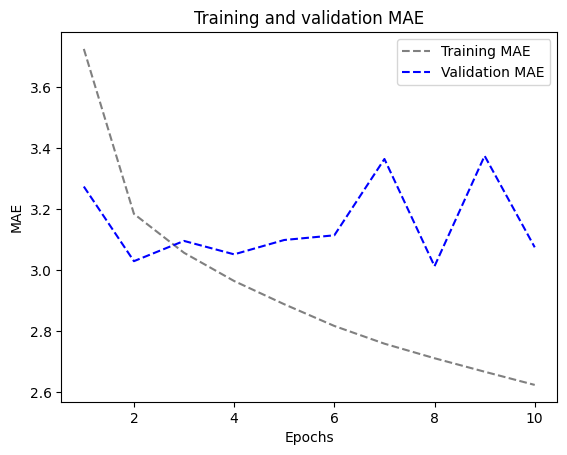

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*It seem that the convolutional data perform worse compared to common sense or dense model. it could be because*

*- The assumption of translation invariance does not hold well for weather data.*

*- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.*






## **A Simple RNN**

### **1.An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 21ms/step - loss: 138.7924 - mae: 9.7006 - val_loss: 144.3807 - val_mae: 9.9457
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 136.6465 - mae: 9.5849 - val_loss: 143.9269 - val_mae: 9.8997
Epoch 3/10
819/819 [==============================] - 17s 21ms/step - loss: 136.3873 - mae: 9.5607 - val_loss: 143.7465 - val_mae: 9.8743
Epoch 4/10
819/819 [==============================] - 18s 22ms/step - loss: 136.2435 - mae: 9.5435 - val_loss: 143.6132 - val_mae: 9.8570
Epoch 5/10
819/819 [==============================] - 18s 21ms/step - loss: 136.1981 - mae: 9.5392 - val_loss: 143.5833 - val_mae: 9.8543
Epoch 6/10
819/819 [==============================] - 17s 21ms/step - loss: 136.1777 - mae: 9.5387 - val_loss: 143.5724 - val_mae: 9.8548
Epoch 7/10
819/819 [==============================] - 17s 21ms/step - loss: 136.1583 - mae: 9.5356 - val_loss: 143.5698 - val_mae: 9.8515
Epoch 8/10
819/819 [==============

### **2.Simple RNN - Stacking RNN layers**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 57s 66ms/step - loss: 136.7554 - mae: 9.5662 - val_loss: 143.4577 - val_mae: 9.8456
Epoch 2/10
819/819 [==============================] - 54s 66ms/step - loss: 135.9773 - mae: 9.5159 - val_loss: 143.4651 - val_mae: 9.8409
Epoch 3/10
819/819 [==============================] - 54s 66ms/step - loss: 135.9227 - mae: 9.5081 - val_loss: 143.4563 - val_mae: 9.8411
Epoch 4/10
819/819 [==============================] - 54s 66ms/step - loss: 135.8846 - mae: 9.5030 - val_loss: 143.4282 - val_mae: 9.8366
Epoch 5/10
819/819 [==============================] - 54s 65ms/step - loss: 135.8708 - mae: 9.5006 - val_loss: 143.4453 - val_mae: 9.8400
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 135.8538 - mae: 9.4976 - val_loss: 143.4491 - val_mae: 9.8409
Epoch 7/10
819/819 [==============================] - 54s 66ms/step - loss: 135.8565 - mae: 9.4978 - val_loss: 143.4279 - val_mae: 9.8392
Epoch 8/10
819/819 [==============

## **A Simple GRU (Gated Recurrent Unit)**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 51ms/step - loss: 41.5242 - mae: 4.6926 - val_loss: 12.6422 - val_mae: 2.6797
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 10.6292 - mae: 2.5395 - val_loss: 9.1019 - val_mae: 2.3435
Epoch 3/10
819/819 [==============================] - 42s 52ms/step - loss: 9.5830 - mae: 2.4216 - val_loss: 9.0860 - val_mae: 2.3429
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 9.2409 - mae: 2.3735 - val_loss: 9.3492 - val_mae: 2.3730
Epoch 5/10
819/819 [==============================] - 42s 52ms/step - loss: 9.0411 - mae: 2.3450 - val_loss: 9.4908 - val_mae: 2.3825
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 8.8774 - mae: 2.3228 - val_loss: 9.2739 - val_mae: 2.3583
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 8.7226 - mae: 2.3028 - val_loss: 9.1004 - val_mae: 2.3424
Epoch 8/10
819/819 [==============================] - 42s 5

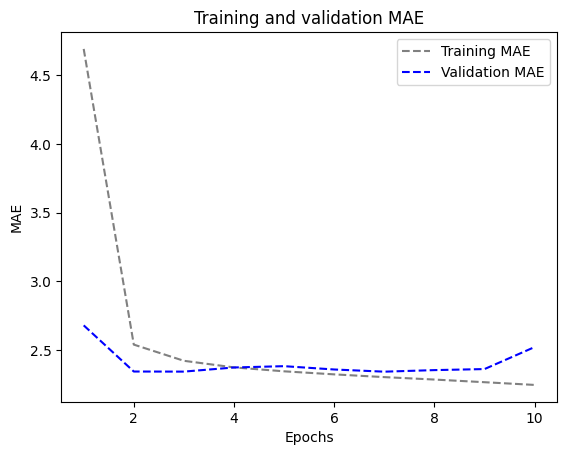

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory )**

### **1.LSTM-Simple**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 55ms/step - loss: 40.9992 - mae: 4.6805 - val_loss: 12.8009 - val_mae: 2.7204
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 11.1815 - mae: 2.6019 - val_loss: 10.1020 - val_mae: 2.4575
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 9.9287 - mae: 2.4581 - val_loss: 9.6784 - val_mae: 2.4080
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 9.5564 - mae: 2.4059 - val_loss: 9.4899 - val_mae: 2.3894
Epoch 5/10
819/819 [==============================] - 44s 53ms/step - loss: 9.2829 - mae: 2.3676 - val_loss: 9.3406 - val_mae: 2.3704
Epoch 6/10
819/819 [==============================] - 44s 54ms/step - loss: 9.0682 - mae: 2.3378 - val_loss: 9.6171 - val_mae: 2.4087
Epoch 7/10
819/819 [==============================] - 44s 54ms/step - loss: 8.8744 - mae: 2.3108 - val_loss: 9.6770 - val_mae: 2.4093
Epoch 8/10
819/819 [==============================] - 44s 

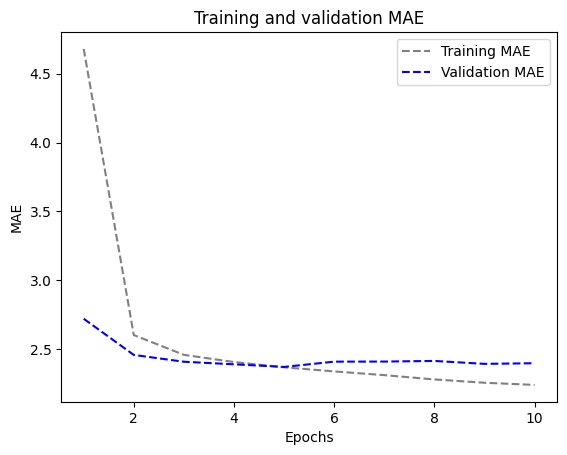

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **2.LSTM - dropout Regularization**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 61s 71ms/step - loss: 45.2395 - mae: 5.0054 - val_loss: 12.7789 - val_mae: 2.7251
Epoch 2/10
819/819 [==============================] - 59s 71ms/step - loss: 20.1363 - mae: 3.4513 - val_loss: 10.3101 - val_mae: 2.5083
Epoch 3/10
819/819 [==============================] - 59s 73ms/step - loss: 18.6436 - mae: 3.3246 - val_loss: 9.6511 - val_mae: 2.4311
Epoch 4/10
819/819 [==============================] - 59s 72ms/step - loss: 17.5215 - mae: 3.2274 - val_loss: 9.2659 - val_mae: 2.3774
Epoch 5/10
819/819 [==============================] - 59s 72ms/step - loss: 16.9218 - mae: 3.1666 - val_loss: 9.3421 - val_mae: 2.3843
Epoch 6/10
819/819 [==============================] - 59s 72ms/step - loss: 16.5315 - mae: 3.1332 - val_loss: 9.1740 - val_mae: 2.3679
Epoch 7/10
819/819 [==============================] - 61s 74ms/step - loss: 16.0297 - mae: 3.0895 - val_loss: 9.2736 - val_mae: 2.3787
Epoch 8/10
819/819 [==============================] -

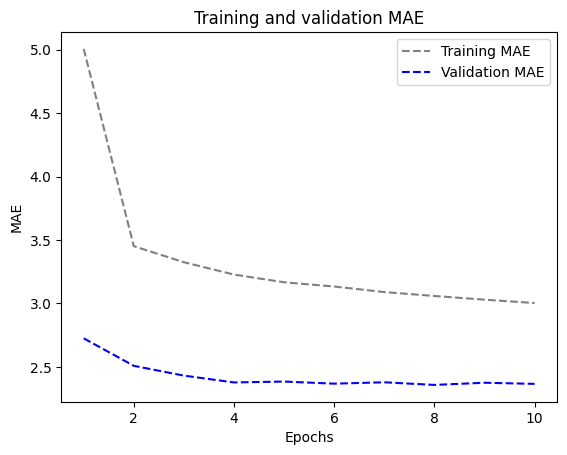

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **3.LSTM - Stacked setup with 16 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 92s 108ms/step - loss: 42.0220 - mae: 4.7276 - val_loss: 12.9326 - val_mae: 2.7155
Epoch 2/10
819/819 [==============================] - 88s 108ms/step - loss: 10.4137 - mae: 2.5023 - val_loss: 9.2121 - val_mae: 2.3573
Epoch 3/10
819/819 [==============================] - 90s 110ms/step - loss: 8.8353 - mae: 2.3177 - val_loss: 9.8595 - val_mae: 2.4323
Epoch 4/10
819/819 [==============================] - 89s 109ms/step - loss: 8.2430 - mae: 2.2422 - val_loss: 9.6070 - val_mae: 2.4117
Epoch 5/10
819/819 [==============================] - 89s 108ms/step - loss: 7.7582 - mae: 2.1819 - val_loss: 9.4796 - val_mae: 2.3987
Epoch 6/10
819/819 [==============================] - 88s 107ms/step - loss: 7.2837 - mae: 2.1171 - val_loss: 9.5176 - val_mae: 2.4032
Epoch 7/10
819/819 [==============================] - 89s 108ms/step - loss: 6.8752 - mae: 2.0551 - val_loss: 11.5418 - val_mae: 2.6705
Epoch 8/10
819/819 [==============================]

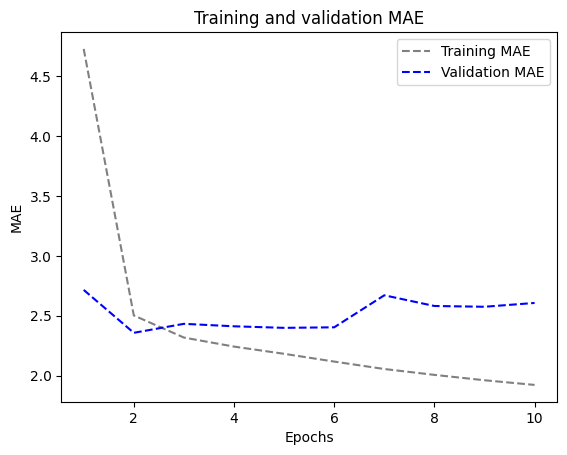

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked setup with 32 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 137s 163ms/step - loss: 20.0605 - mae: 3.2202 - val_loss: 9.7444 - val_mae: 2.4315
Epoch 2/10
819/819 [==============================] - 134s 164ms/step - loss: 7.8106 - mae: 2.1822 - val_loss: 10.6354 - val_mae: 2.5525
Epoch 3/10
819/819 [==============================] - 129s 158ms/step - loss: 6.1545 - mae: 1.9350 - val_loss: 11.5161 - val_mae: 2.6639
Epoch 4/10
819/819 [==============================] - 129s 158ms/step - loss: 5.0637 - mae: 1.7453 - val_loss: 12.1223 - val_mae: 2.7221
Epoch 5/10
819/819 [==============================] - 130s 159ms/step - loss: 4.3425 - mae: 1.6110 - val_loss: 13.0372 - val_mae: 2.8205
Epoch 6/10
819/819 [==============================] - 130s 158ms/step - loss: 3.8168 - mae: 1.5072 - val_loss: 14.2476 - val_mae: 2.9575
Epoch 7/10
819/819 [==============================] - 132s 161ms/step - loss: 3.3606 - mae: 1.4129 - val_loss: 14.6092 - val_mae: 3.0047
Epoch 8/10
819/819 [=====================

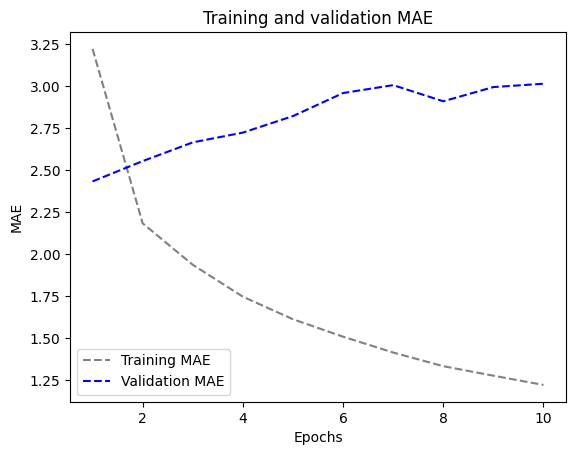

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked setup with 8 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 84s 96ms/step - loss: 64.1802 - mae: 6.0847 - val_loss: 31.4408 - val_mae: 4.1349
Epoch 2/10
819/819 [==============================] - 77s 94ms/step - loss: 19.2954 - mae: 3.2511 - val_loss: 12.3955 - val_mae: 2.6608
Epoch 3/10
819/819 [==============================] - 77s 94ms/step - loss: 10.7764 - mae: 2.5324 - val_loss: 10.1745 - val_mae: 2.4398
Epoch 4/10
819/819 [==============================] - 74s 90ms/step - loss: 9.6899 - mae: 2.4150 - val_loss: 10.0503 - val_mae: 2.4546
Epoch 5/10
819/819 [==============================] - 73s 89ms/step - loss: 9.3284 - mae: 2.3743 - val_loss: 9.3463 - val_mae: 2.3636
Epoch 6/10
819/819 [==============================] - 73s 89ms/step - loss: 9.0719 - mae: 2.3443 - val_loss: 11.0032 - val_mae: 2.5082
Epoch 7/10
819/819 [==============================] - 73s 89ms/step - loss: 8.8230 - mae: 2.3160 - val_loss: 9.3469 - val_mae: 2.3690
Epoch 8/10
819/819 [==============================] - 

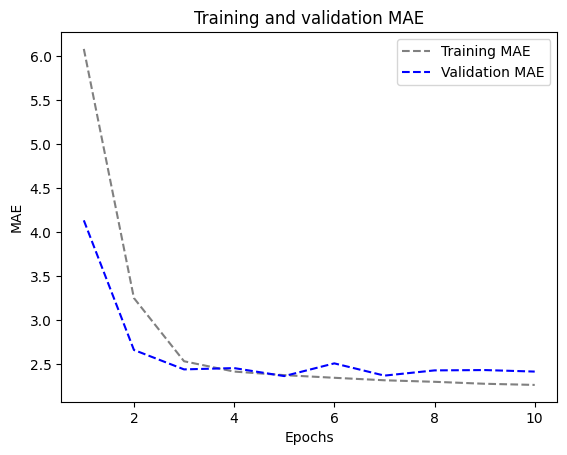

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **5.LSTM - dropout-regularized, stacked model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 110s 129ms/step - loss: 76.4923 - mae: 6.7366 - val_loss: 37.6573 - val_mae: 4.5464
Epoch 2/10
819/819 [==============================] - 105s 128ms/step - loss: 32.7365 - mae: 4.2628 - val_loss: 14.4797 - val_mae: 2.8360
Epoch 3/10
819/819 [==============================] - 104s 127ms/step - loss: 24.6575 - mae: 3.7489 - val_loss: 10.8112 - val_mae: 2.5176
Epoch 4/10
819/819 [==============================] - 106s 129ms/step - loss: 22.4720 - mae: 3.5893 - val_loss: 10.2903 - val_mae: 2.4759
Epoch 5/10
819/819 [==============================] - 106s 129ms/step - loss: 21.0787 - mae: 3.4736 - val_loss: 9.7520 - val_mae: 2.4119
Epoch 6/10
819/819 [==============================] - 106s 130ms/step - loss: 19.9963 - mae: 3.3899 - val_loss: 9.9300 - val_mae: 2.4371
Epoch 7/10
819/819 [==============================] - 106s 130ms/step - loss: 19.2050 - mae: 3.3243 - val_loss: 9.5187 - val_mae: 2.3836
Epoch 8/10
819/819 [=================

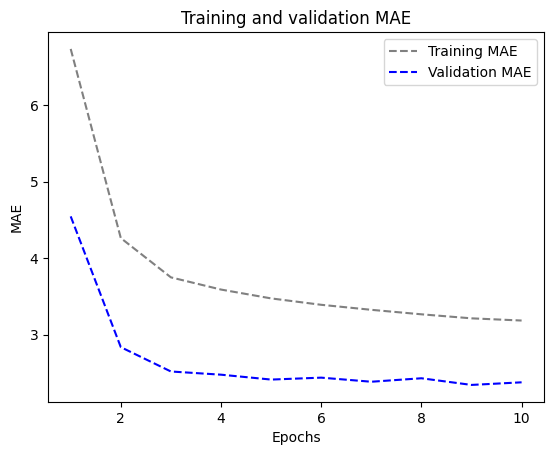

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **Bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 55s 63ms/step - loss: 28.3734 - mae: 3.8164 - val_loss: 11.0705 - val_mae: 2.5875
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 9.6507 - mae: 2.4226 - val_loss: 9.8751 - val_mae: 2.4323
Epoch 3/10
819/819 [==============================] - 51s 63ms/step - loss: 8.7244 - mae: 2.2977 - val_loss: 10.1776 - val_mae: 2.4780
Epoch 4/10
819/819 [==============================] - 48s 59ms/step - loss: 8.1728 - mae: 2.2284 - val_loss: 10.1203 - val_mae: 2.4558
Epoch 5/10
819/819 [==============================] - 47s 58ms/step - loss: 7.7554 - mae: 2.1718 - val_loss: 10.4155 - val_mae: 2.4755
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 7.4904 - mae: 2.1366 - val_loss: 10.5281 - val_mae: 2.4869
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 7.2146 - mae: 2.0968 - val_loss: 10.4031 - val_mae: 2.4935
Epoch 8/10
819/819 [==============================] - 4

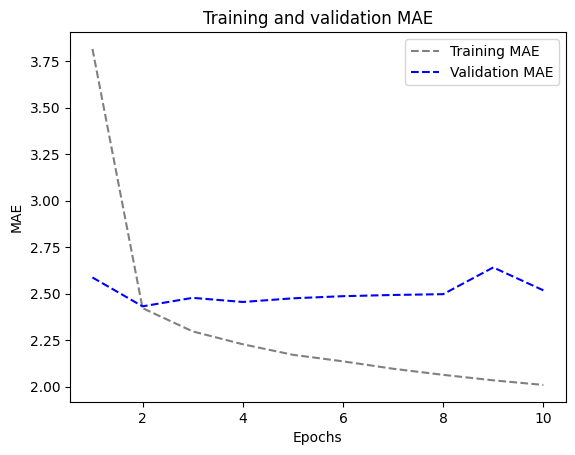

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **1D Convnets and LSTM togther**

In [ ]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 20ms/step - loss: 49.2474 - mae: 5.2556 - val_loss: 25.2778 - val_mae: 3.8680
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 17.9254 - mae: 3.2846 - val_loss: 23.3230 - val_mae: 3.7986
Epoch 3/10
819/819 [==============================] - 16s 19ms/step - loss: 14.8910 - mae: 3.0042 - val_loss: 23.9210 - val_mae: 3.8602
Epoch 4/10
819/819 [==============================] - 15s 19ms/step - loss: 13.2011 - mae: 2.8236 - val_loss: 22.4376 - val_mae: 3.7737
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 12.0171 - mae: 2.6891 - val_loss: 28.6422 - val_mae: 4.2287
Epoch 6/10
819/819 [==============================] - 16s 19ms/step - loss: 11.1359 - mae: 2.5809 - val_loss: 24.8776 - val_mae: 4.0289
Epoch 7/10
819/819 [==============================] - 16s 19ms/step - loss: 10.4522 - mae: 2.4934 - val_loss: 22.6913 - val_mae: 3.8233
Epoch 8/10
819/819 [============================

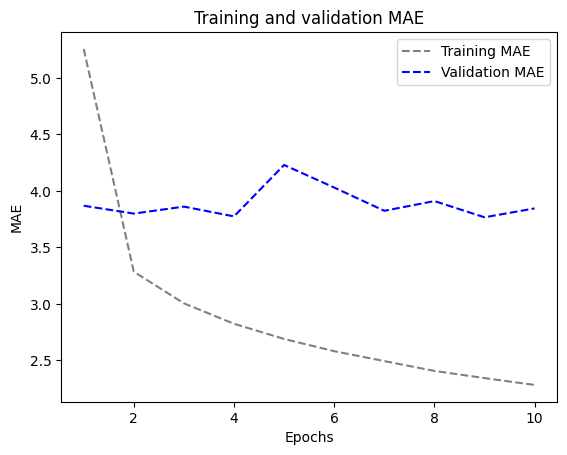

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We built 13 models: Following are the details;

**Model 1:** common-sense, non-machine-learning baseline

**Model 2:** A basic machine-learning model

**Model 3:** 1D convolutional model

**Model 4:** Simple RNN layer that can process sequences of any length

**Model 5:** Simple RNN - Stacking RNN layers

**Model 6:** A Simple GRU (Gated Recurrent Unit)

**Model 7:** LSTM-Simple

**Model 8:** LSTM - dropout Regularization

**Model 9:** LSTM Stacked setup with 16 units

**Model 10:** LSTM Stacked setup with 32 units

**Model 11:** LSTM Stacked setup with 8 units

**Model 12:** LSTM - dropout-regularized, stacked up with 8unit

**Model 13:** Bidirectional LSTM

**Model 14:** 1D Convnets and LSTM togther

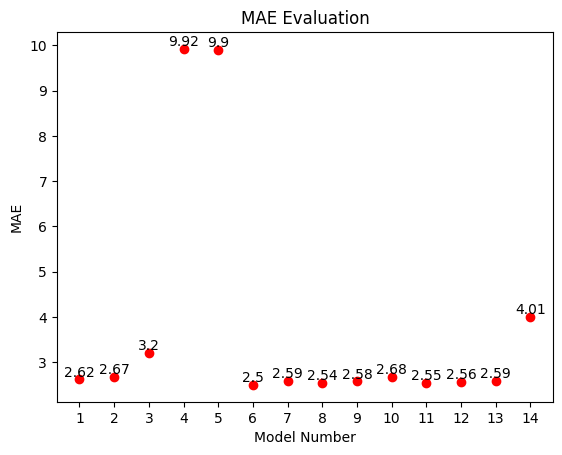

In [ ]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

<u>**Conclusion:-**</u> We created 14 models total. The first one is not a machine learning model , it’s just the common sense base line method which was giving 2.62 MAE. Later we created the basic machine learning model(danse layer) which gave 2.67 MAE which is slightly higher than the common sense method MAE. The dense layer is not performing well because the connected approach first flattened the timeseries, which removed the notion of time from the input data. We also tried convolution model but it was giving us very poor results because the convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed the order of information.
Hence there is a specific architecture for time series data which is RNN (Recurrent Neural Networks). The key characteristic of an RNN is its ability to use information from previous steps in its current decision-making process. This enables the network to capture dependencies and patterns within sequential data. The internal state of an RNN serves as a memory of the previous inputs it has seen, making it capable of modeling sequences of arbitrary lengths. The simple RNN is generally too simplistic to be of real use. In particular, SimpleRNN has a major issue: As we can see from the graph as well, the simple RNN is the worst performer among all. Theoretically, the SimpleRNN at any time t can retain information for all previous time periods, however, practically it makes learning in the network difficult. This is due to the** vanishing gradient problem**, whereby for deep networks, the network becomes untrainable. The LSTM and GRU RNNs were developed to address this problem and are included as part of Keras. We tried the simple GRU and it showed the best result among all the models due to its ability to capture long-range dependencies in sequential data while being computationally less expensive compared to LSTMs.

LSTMs are one of the most famous architecture to handle time series data and we ran 6 different models for LSTM by changing the units in Stacking recurrent layers to 8,16 and 32. 8 gave the best result among all the 3 units. We also tried Recurrent dropout to avoid overfitting and Bidirectional data which presents the same information to a recurrent network in different ways, increasing accuracy and mitigating the forgetting issue. All of these models have MAE values near to each other and are also lower than the common sense model. We can confirm the same from the MAE evaluation graph.

At the end we also build a model using a combination of 1D convolution model and RNN but it gave a poor 4.01 MAE probably because of the Convolution limitation which is destroying order of information.

<u>**Recommendation:-**</u> As I have observed, simple RNNs suffer from the vanishing gradient problem, making them less effective in capturing long-term dependencies. It's advisable to use more advanced RNN architectures, such as LSTM and GRU, which are designed to mitigate these issues. Also, LSTM is a popular choice for handling time series data due to its ability to capture long-term dependencies, **but experiments have shown that GRU can be a more efficient option. I recommend to try to optimize GRU by tuning the hyperparameters such as the number of units in the stacked recurrent layers, the recurrent dropout rate, and the use of bidirectional data**

Based on the results I obtained, the combination of 1D convolution and RNN did not yield the best performance. Given the limitations of the convolutional approach in destroying the order of information in your time series data, **it's advisable to focus on architectures that are specifically designed for handling sequential data, such as pure RNNs.**
